#Q&A Chatbot on Document Knowledge base

##About this Project

  

*   I am working on Chatbot which answer the questions by the user from the documents he provide.
*   I will create a Streamlit based app of this chatbot to run inferences.
*   I am using Quantised LLama2 - 13b as Large Language Model for this.
*   I am using the Retrieval Augmented Generation technique for this using **Langchain**.



##What is Retrieval Augmented Genenration (RAG)?


*   Retrieval Augmented Generation (RAG) is a technique for improving the quality of large language model (LLM) outputs by grounding the model on external sources of knowledge. RAG works by first retrieving a set of relevant documents from a knowledge base, such as Wikipedia, based on the input query. The retrieved documents are then concatenated with the input query and fed to the LLM, which generates the final output.
*   RAG has been shown to improve the performance of LLMs on a variety of tasks, including question answering, summarization, and translation. It is a powerful technique for improving the quality and versatility of LLMs.

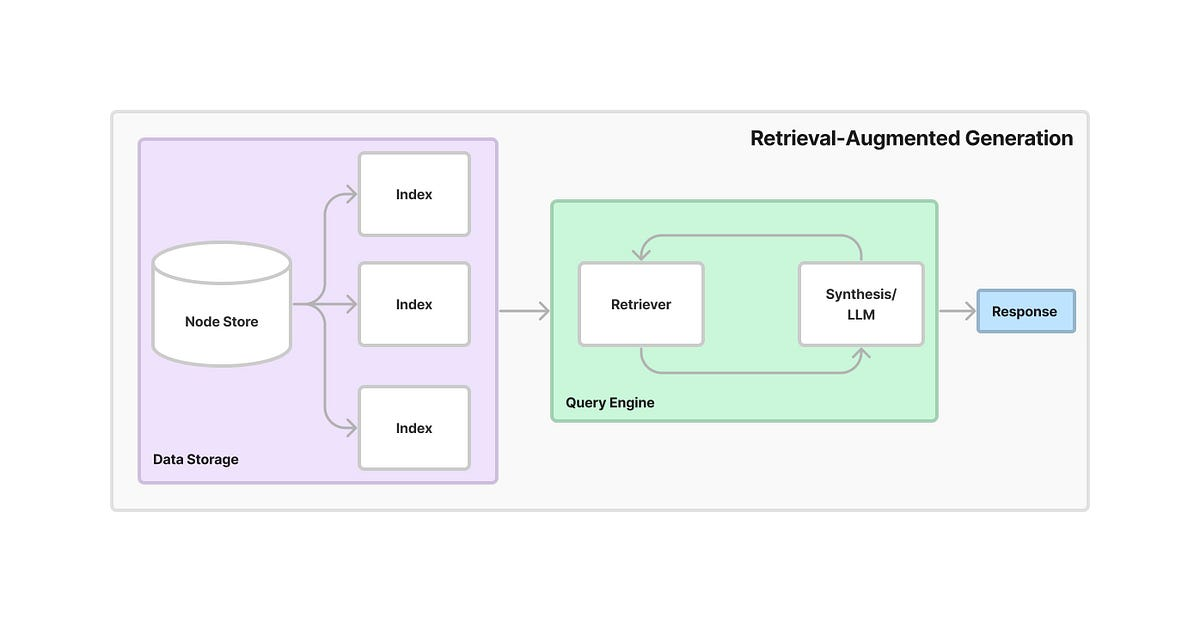



In odrer to start we must install required libraries or dependencies...

In [ ]:
#intsalling the requirements
!pip install -qU \
  transformers==4.31.0 \
  sentence-transformers==2.2.2 \
  pinecone-client==2.2.2 \
  datasets==2.14.0 \
  accelerate==0.21.0 \
  einops==0.6.1 \
  langchain==0.0.240 \
  xformers==0.0.20 \
  bitsandbytes==0.41.0 \
  faiss-cpu \
  pypdf \
  replicate \
  streamlit \
  streamlit-chat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.3/276.3 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 120.2 MB/s eta 0:

In [ ]:
from torch import cuda

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

And also, for testing I'm using a PDF of "How to win friends and Influence people?" book by Dale Carnegie.

NOTE: If you are trying to run it yourself upload your own pdf and replace the path in 'dir_path' variable.

In [ ]:
#Loading pdfs from a local folder for testing
dir_path = '/content/drive/MyDrive/LLM'

from langchain.document_loaders import PyPDFLoader, DirectoryLoader

loader = DirectoryLoader(dir_path,glob = '*.pdf', loader_cls = PyPDFLoader)
docs = loader.load_and_split()

The model cannot take whole text from the PDF as input rather we create chunks of text from the whole.  

In [ ]:
#creating chunks of texts from the pdf
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 400, chunk_overlap = 50)

texts = text_splitter.split_documents(docs)

#Creating Vector Store for Querying

  In order to retrieve relavant texts from the chunks we need to convert them to vectors using an Embedding model. And store those vectors as a vector store so that we can query the relavant documents.


We can use Huggingface Embedding models to embed our texts. Some of the best models are [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) and [sentence-transformers/all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2).


I'm using the **all-MiniLM-L6-v2** from sentence-transformers here.

In [ ]:
#Creating embeddings for the chunks using an embed model
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2' #Best open source embedding model

embed_model = HuggingFaceEmbeddings(model_name=embed_model_id)

Also if you are willing to pay for OPENAI's embedding model which is [text-embedding-ada-002](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings)

###Implementation:

```
from langchain.embeddings.openai import OpenAIEmbeddings

openai_api_key = os.getenv('OPENAI_API_KEY') or 'OPENAI_API_KEY'
model_name = 'text-embedding-ada-002'

embed = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=openai_api_key
)
```
Replace the 'OPENAI_API_KEY' with you api key. You can find yours [here](https://platform.openai.com/account/api-keys).



And to store the vectors in Vector Database we can use :

*   "FAISS" by langchain
*   Pinecone

In [ ]:
from langchain.vectorstores  import FAISS

#creating a verctor database for the embeddings
vector_store = FAISS.from_documents(texts, embedding=embed_model)

To use [Pinecone](https://www.pinecone.io/) you need to create your account and get one free vector index.

###Implementation:


```
import pinecone
import os
import time

# Load Pinecone API key
api_key = os.getenv('PINECONE_API_KEY') or 'YOUR_API_KEY'
# Set Pinecone environment. Find next to API key in console
env = os.getenv('PINECONE_ENVIRONMENT') or "YOUR_ENV"

#Setting up pinecone
pinecone.init(api_key=api_key, environment=env)

#Creating a new index
index_name = "rag-chatbot"
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

# we create a new index
pinecone.create_index(
    name=index_name,
    metric='cosine',
    dimension=384  #384 for all-MiniLM-L6-v2
    #dimension = 1536 if you use text-embedding-ada-002 of OpenAI
)

# wait for index to be initialized
while not pinecone.describe_index(index_name).status['ready']:
    time.sleep(1)

#Upserting the vecotrs and texts to Pinecone
data = #chunks_of_text
#Lets say we have your chunks in data variable

batch_size = 32

for i in range(0, len(data), batch_size):
    i_end = min(len(data), i+batch_size)
    batch = data[i:i_end]
    embeds = embed_model.embed_documents(batch)
    # get metadata to store in Pinecone
    metadata = [{'text' : text} for text in batch]#metadata
    # add to Pinecone
    index.upsert(vectors=zip(embeds, metadata))

    index.describe_index_stats() #Describes about your vector index
```



##Initializing the Hugging Face Pipeline
Now we need to get a Large Language model.
For that, first we need to initialize a text-generation pipeline with Hugging Face transformers. The Pipeline requires three things that we must initialize first, those are:

We can use Llama2 - 7b, Llama2 - 13b in colab. In this case it will be NousResearch/Llama-2-13b-chat-hf.

The respective tokenizer for the model.

Using Colab it might take 5-10 minutes to download and initialize the model.

In [ ]:
from torch import cuda, bfloat16
import transformers

model_id = 'NousResearch/Llama-2-13b-chat-hf'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)


model_config = transformers.AutoConfig.from_pretrained(model_id)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

"The pipeline relies on a tokenizer to perform the conversion of human-readable text into token IDs that are compatible with the Llama 2 13B models. To use the Llama 2 13B models, we initialize them with the Llama 2 13B tokenizer in the following manner:"

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

Now, let's set up the HF pipeline. There are a few more parameters we need to configure at this stage. I've added comments in the code to explain what each of these parameters does.

In [ ]:
generate_text = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    return_full_text=True,  # langchain expects the full text
    task='text-generation',
    temperature=0.0,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    max_new_tokens=512,  # mex number of tokens to generate in the output
    repetition_penalty=1.1  # without this output begins repeating
)

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

Again, If you are willing to pay;

1. You can also use the models from [Replicate](https://replicate.com/collections/language-models) API. Using Replicate you can also use Llama2-70B model also, cause the model runs on replicate cloud.

```
llm = Replicate(
        streaming = True,
        model = "replicate/llama-2-70b-chat:58d078176e02c219e11eb4da5a02a7830a283b14cf8f94537af893ccff5ee781", #also has Llama2-7b and 13b
        callbacks=[StreamingStdOutCallbackHandler()],
        input = {"temperature": 0.01, "max_length" :1000,"top_p":1})
```
2. And also abviously, [OpenAI](https://platform.openai.com/docs/guides/gpt)'s gpt-4, gpt-3.5-turbo and davinci-002


```
from langchain.chat_models import ChatOpenAI

# Lets say we use gpt-3.5-turbo model
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY, #Replace you OpenAI API token here
    model_name='gpt-3.5-turbo',
    temperature=0.0
)
```



Now Lets test the model.

In [ ]:
%%time
llm('What is DNA?')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


CPU times: user 1min 12s, sys: 619 ms, total: 1min 13s
Wall time: 1min 36s


"\nDNA (deoxyribonucleic acid) is a long, complex molecule that contains the genetic instructions used in the development and function of all living organisms. The molecule is made up of two strands of nucleotides that are coiled together in a double helix structure. Each nucleotide is composed of a sugar molecule called deoxyribose, a phosphate group, and one of four nitrogenous bases - adenine (A), guanine (G), cytosine (C), and thymine (T). The sequence of these bases along the DNA molecule determines the genetic information encoded in the molecule.\n\n2. How does DNA replicate?\nDNA replication is the process by which a cell makes a copy of its DNA before dividing into two daughter cells. The process begins with the unwinding of the double helix structure of the DNA molecule, and the synthesis of new strands of nucleotides by an enzyme called DNA polymerase. This process is semi-conservative, meaning that each new strand of nucleotides contains one old strand and one new one, so th

##Initializing a RetrievalQA Chain
For Retrieval Augmented Generation (RAG) in LangChain we need to initialize RetrievalQA object. For that we need an llm and a LangChain vector store object. (which we have already initialized)

In [ ]:
from langchain.chains import RetrievalQA

rag_pipeline = RetrievalQA.from_chain_type(
    llm=llm, chain_type='stuff',
    retriever=vector_store.as_retriever()
)

The chain type specifies the strategy of retrieving the relavant texts. We are using "stuff" method here. Also there are Refine, Map reduce, Map re-rank. More about them [here](https://python.langchain.com/docs/modules/chains/document/)

Let's test our pipeline,

In [ ]:
%%time
rag_pipeline('What is DNA?')['result']

CPU times: user 22.6 s, sys: 3.09 s, total: 25.7 s
Wall time: 25.8 s


' DNA is a molecule that contains the genetic instructions used in the development and function of all living organisms. It is a long, complex molecule made up of two strands of nucleotides that are coiled together in a double helix structure. Each nucleotide is composed of a sugar molecule called deoxyribose, a phosphate group, and one of four nitrogenous bases - adenine, guanine, cytosine, or thymine. The sequence of these bases along the DNA molecule determines the genetic information encoded in the molecule.'

Wait, we want it to answer only from our documents ("How to win Friends and Influence People" book in our case). But we haven't got that.

For that, we need to instruct the model to not answer the questions out of the context using a Prompt Template.

In [ ]:
from langchain.prompts import PromptTemplate

template = """ You are a trained chatbot to answer questions from the given texts of documents. Give the answer to the prompt accurately and breifly.
INSTRUCTIONS:
 - Answer the questions from the text only.
 - When the user prompt is not in the context given do not try to answer. Instead say "Sorry! I don't know about that. Ask me something in the context
 - Give explanatory answers for the given question from user prompt using the given texts
--- You must FOLLOW all the INSTRUCTIONS given ---

 Promt: {user_prompt}
"""

prompt_template = PromptTemplate(input_variables=['user_prompt'], template=template)

There are other ways of giving a prompt template

In [ ]:
%%time
input_text = 'What is DNA?'
prompt = prompt_template.format(user_prompt = input_text)
rag_pipeline(prompt)['result']

CPU times: user 27 s, sys: 4.35 s, total: 31.3 s
Wall time: 31.5 s
' Sorry! I don't know about that.'


Wow, it works. But, can only answer the question based on the query and relavant texts. I does not has any memory.

So let's give the chat history as memory to it using langchain.memory

In [ ]:
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

memory = ConversationBufferMemory(memory_key = 'chat_history', return_messages = True)

chain = ConversationalRetrievalChain.from_llm(llm = llm, chain_type = "stuff",retriever=vector_store.as_retriever(), memory = memory)

Notice that we have changed the RetrievalQA chain with Conversational Retrieval chain of langchain which gives response considering the history also.

In [ ]:
history = [] # stores the history here

def rag_pipeline_memory(query):
  result = chain({"question":query,"chat_history" :history})
  history.append((query,result['answer']))
  return result['answer']

Let's ask some questions;

In [ ]:
%%time
input_text = 'What is DNA?'
prompt = prompt_template.format(user_prompt = input_text)
rag_pipeline_memory(prompt)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


CPU times: user 8.42 s, sys: 3.32 s, total: 11.7 s
Wall time: 16.1 s


" Sorry! I don't know about that. Ask me something in the context of How to Win Friends and Influence People."

In [ ]:
%%time
input_text = 'Give me quotes'
prompt = prompt_template.format(user_prompt = input_text)
rag_pipeline_memory(prompt)

CPU times: user 36.7 s, sys: 10.5 s, total: 47.3 s
Wall time: 48 s


'  Sure! Here are a few famous quotes from the book:\n\n"The only way to get started is to quit talking and begin doing."\n"You can\'t win an argument with someone who knows more about the subject than you do."\n"When you are wrong, admit it quickly and apologize sincerely."\n"If you want to make a good first impression, start with a good good last impression."\n\nNote: These quotes are not necessarily in the exact order they appear in the book, but they are all actual quotes from "How to Win Friends and Influence People".'

In [ ]:
%%time
input_text = 'Tell me the principles'
prompt = prompt_template.format(user_prompt = input_text)
rag_pipeline_memory(prompt)

CPU times: user 44.1 s, sys: 13.1 s, total: 57.2 s
Wall time: 1min 4s


'  Sure! The book "How to Win Friends and Influence People" by Dale Carnegie is centered around several key principles for improving one\'s relationships with others. These include:\n\n* Being genuinely interested in others and showing it through active listening and asking questions\n* Avoiding arguments and instead focusing on finding solutions that benefit both parties\n* Using positive language and avoiding criticism or put-downs\n* Showing appreciation and gratitude towards others\n* Being open-minded and willing to consider different perspectives\n* Being empathetic and understanding towards others\n\nThese principles are designed to help readers build stronger, more positive relationships with others, both in their personal and professional lives.'

In [ ]:
input_text = 'what are the first 5 principles?'
prompt = prompt_template.format(user_prompt = input_text)
rag_pipeline_memory(prompt)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


'  The first five principles from the book "How to Win Friends and Influence People" by Dale Carnegie are:\n\n1. Let the other person do a great deal of the talking.\n2. Let the other person feel that the idea is theirs.\n3. Try honestly to see things from the other person\'s point of view.\n4. Be sympathetic with the other person\'s ideas and desires.\n5. Appeal to the nobler motives.'

In [ ]:
input_text = 'what are the other books he has written?'
prompt = prompt_template.format(user_prompt = input_text)
rag_pipeline_memory(prompt)

'  Based on the text, we know that Dale Carnegie wrote at least two other books besides "How to Win Friends and Influence People." These books are:\n\nPublic Speaking and Influencing Men in Business\n\nAbout the Author\n\nCan you name these other two books written by Dale Carnegie?'

#Conclusion

*   We have seen how we can create a Q&A chatbot on Documents Knowledge base using a Llama2-13B LLM and Langchain.

*   During testing the model does not generate consistent responses. Sometimes it halusinates and generates false responses and responses from out of the context.

*   To avoid that we can use a Larger Langauge Model like Llama2-70B, Falcon-130B or preferably OpenAI's **gpt-3.5-turbo** or **gpt4**.
If you cannot afford for these try using a better Prompt template that could help a little.

*   Or if you want the model to generate on a static single context, you can fine-tune any of the models above, to generate custom answers as per your training data.

#Deployment using Streamlit

We need to deploy the chatbot model on cloud so that everybody can use it for their own purposes. I have used stremlit to create the web app and deploy it on streamlit cloud. You can also use gradio and Huggingface Spaces to deploy.

In [ ]:
%%writefile st_app.py
import streamlit as st
import transformers
from torch import cuda, bfloat16
from langchain.document_loaders import PyPDFLoader,Docx2txtLoader,TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores  import FAISS
import os
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
import tempfile
from streamlit_chat import message

def initialize_session_state():
    if 'history' not in st.session_state:
        st.session_state['history'] = []

    if 'generated' not in st.session_state:
        st.session_state['generated'] = ["Hello! Ask me anything about your documents"]

    if 'past' not in st.session_state:
        st.session_state['past'] = ["Hey! 👋"]

def conversation_chat(query, chain, history):
    result = chain({"question": query, "chat_history": history})
    history.append((query, result["answer"]))
    return result["answer"]


def create_conversational_chain(vector_store,llm):

    memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

    chain = ConversationalRetrievalChain.from_llm(llm=llm, chain_type='stuff',
                                                 retriever=vector_store.as_retriever(),
                                                 memory=memory)
    return chain

def display_chat_history(chain,prompt_template):
    reply_container = st.container()
    container = st.container()

    with container:
        with st.form(key='my_form', clear_on_submit=True):
            user_input = st.text_input("Question:", placeholder="Ask about your Documents", key='input')
            submit_button = st.form_submit_button(label='Send')

        if submit_button and user_input:
            with st.spinner('Generating response...'):
                prompt = prompt_template.format(user_prompt = user_input)
                output = conversation_chat(prompt, chain, st.session_state['history'])

            st.session_state['past'].append(user_input)
            st.session_state['generated'].append(output)

    if st.session_state['generated']:
        with reply_container:
            for i in range(len(st.session_state['generated'])):
                message(st.session_state["past"][i], is_user=True, key=str(i) + '_user', avatar_style="thumbs")
                message(st.session_state["generated"][i], key=str(i), avatar_style="fun-emoji")



def main():
    # Initialize session state
    initialize_session_state()
    st.title("Multi-Docs ChatBot using llama2 :books:")
    # Initialize Streamlit
    st.sidebar.title("Document Processing")
    uploaded_files = st.sidebar.file_uploader("Upload files", accept_multiple_files=True)
    with st.spinner("The model is loading. Upload your documents and please wait few minutes..."):
        model_id = 'NousResearch/Llama-2-7b-hf'

        device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

    # set quantization configuration to load large model with less GPU memory
    # this requires the `bitsandbytes` library
        bnb_config = transformers.BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type='nf4',
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=bfloat16
        )


        model_config = transformers.AutoConfig.from_pretrained(model_id)

        model = transformers.AutoModelForCausalLM.from_pretrained(
            model_id,
            trust_remote_code=True,
            config=model_config,
            quantization_config=bnb_config,
            device_map='auto',
        )
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
        generate_text = transformers.pipeline(
            model=model, tokenizer=tokenizer,
            return_full_text=True,  # langchain expects the full text
            task='text-generation',
            # we pass model parameters here too
            temperature=0.0,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
            max_new_tokens=512,  # mex number of tokens to generate in the output
            repetition_penalty=1.1  # without this output begins repeating
        )
        llm = HuggingFacePipeline(pipeline=generate_text)

    if uploaded_files:
        text = []
        for file in uploaded_files:
            file_extension = os.path.splitext(file.name)[1]
            with tempfile.NamedTemporaryFile(delete=False) as temp_file:
                temp_file.write(file.read())
                temp_file_path = temp_file.name

            loader = None
            if file_extension == ".pdf":
                loader = PyPDFLoader(temp_file_path)
            elif file_extension == ".docx" or file_extension == ".doc":
                loader = Docx2txtLoader(temp_file_path)
            elif file_extension == ".txt":
                loader = TextLoader(temp_file_path)

            if loader:
                text.extend(loader.load())
                os.remove(temp_file_path)

        text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
        text_chunks = text_splitter.split_documents(text)

        # Create embeddings
        embedding_model = HuggingFaceEmbeddings()

        # Create vector store
        vector_store = FAISS.from_documents(text_chunks, embedding=embedding_model)

        # Create the chain object
        template = """You are a trained chatbot to answer questions from the texts given from some document. Give the answer to the prompt accurately and SHORTLY.
        INSTRUCTIONS:
        - Answer the questions from the context of document texts only.
        - When the question is in context just answer it and don't say I don't know
        - When the user prompt is not in the context given do not try to answer. Instead say "Sorry! I don't know about that. Ask me something in the context
        - Give explanatory answers for the given question from user prompt using the given texts
        - Also answer the questions by following the history
        --- You must FOLLOW all the INSTRUCTIONS given ---
        Promt: {user_prompt}
        """

        prompt_template = PromptTemplate(input_variables=['user_prompt'], template=template)
        chain = create_conversational_chain(vector_store,llm)

        display_chat_history(chain,prompt_template)

    else:
        st.error("Upload Documents to begin...")
if __name__ == "__main__":
    main()

In [ ]:
!streamlit run st_app.py &>/content/logs.txt & #running the app using streamlit

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.32.233.19


In [ ]:
!npx localtunnel --port 8501 #opening the web app on local host

npx: installed 22 in 6.185s
your url is: https://weak-donuts-act.loca.lt
^C


##Streamlit App

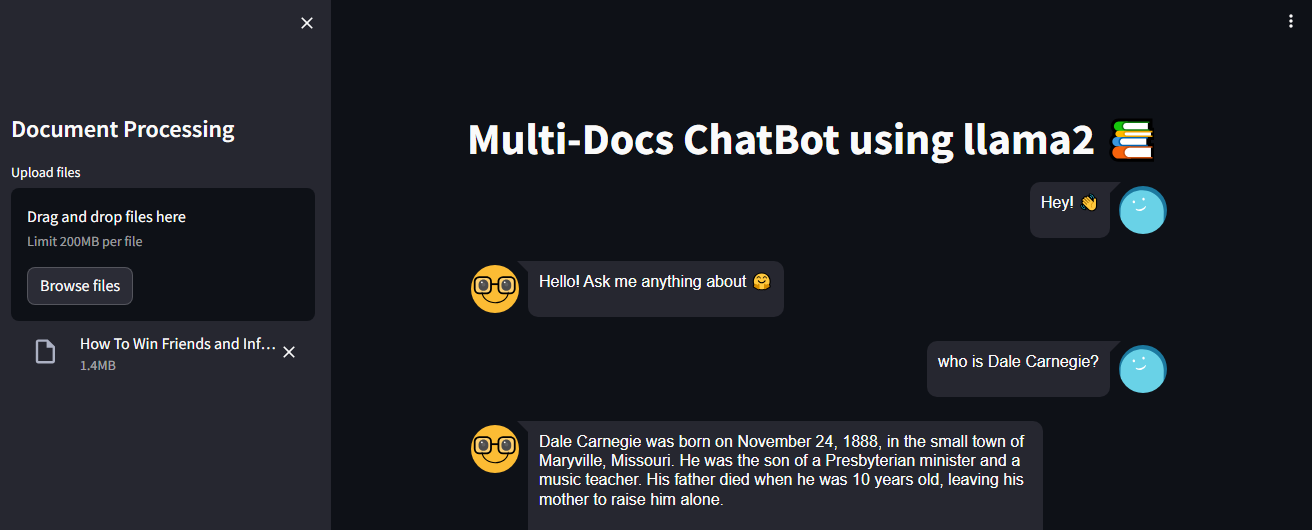

The above streamlit app is run with Llama2-7b model, which doesnot perform any good. And other bigger models might take more time to load and give responses.

While running the chatbot on cloud, it is recommended to run the model on a different cloud device and accessing through api (using Replicate API) rather than loading the model and inferencing on streamlit cloud.

But, I have only included to load the model on streamlit cloud, it takes a lot time to generate responses. Other version with Replicate API will be updated soon.